#Mount DS4A2 as main folder to work from colab
1 - Setup the google drive for using in colab


In [1]:
from google.colab import drive  

In [2]:
drive.mount('/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
%cd /gdrive/My\ Drive/DS4A2 

/gdrive/.shortcut-targets-by-id/15cQeEe0owbmNusdu1b0EqARkzJa2JVvV/DS4A2


In [2]:
%cd /gdrive/.shortcut-targets-by-id/15cQeEe0owbmNusdu1b0EqARkzJa2JVvV/DS4A2/Team/Santiago

/gdrive/.shortcut-targets-by-id/15cQeEe0owbmNusdu1b0EqARkzJa2JVvV/DS4A2/Team/Santiago


#Working with the PB cell dataset


1 - Main packages

In [4]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.model_selection import train_test_split


# Basic imports and commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
#torch.cuda.set_device(2)

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

#sns.set_style("darkgrid")



In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

2 - Read the dataset from the path as dataframe

In [6]:

# path = "./Dataset/PBC_dataset_normal_DIB/" # path Colab
path = "../data/"

In [8]:
train=pd.read_csv(path + "train.csv", index_col=0)
train.reset_index(inplace=True, drop=True)
train.head()

,Nombre,Tipo,Subtipo,Ruta
0,ig_MMY_303957,ig,MMY,ig/MMY_303957.jpg
1,ig_PMY_39029,ig,PMY,ig/PMY_39029.jpg
2,neutrophil_SNE_209710,neutrophil,SNE,neutrophil/SNE_209710.jpg
3,neutrophil_BNE_348065,neutrophil,BNE,neutrophil/BNE_348065.jpg
4,neutrophil_BNE_727973,neutrophil,BNE,neutrophil/BNE_727973.jpg


3 - Proportions of cell types in a pie chart

In [9]:
train['Tipo'].value_counts()

neutrophil      2680
eosinophil      2497
ig              2297
platelet        1884
erythroblast    1242
monocyte        1134
basophil         981
lymphocyte       958
Name: Tipo, dtype: int64

In [11]:
bs = 128 # batch size
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)
data = (ImageList.from_df(train, path=path, cols='Ruta')
       .split_by_rand_pct(valid_pct=0.15, seed=42)
       .label_from_df(cols='Tipo')
       .transform(tfms, size=224)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

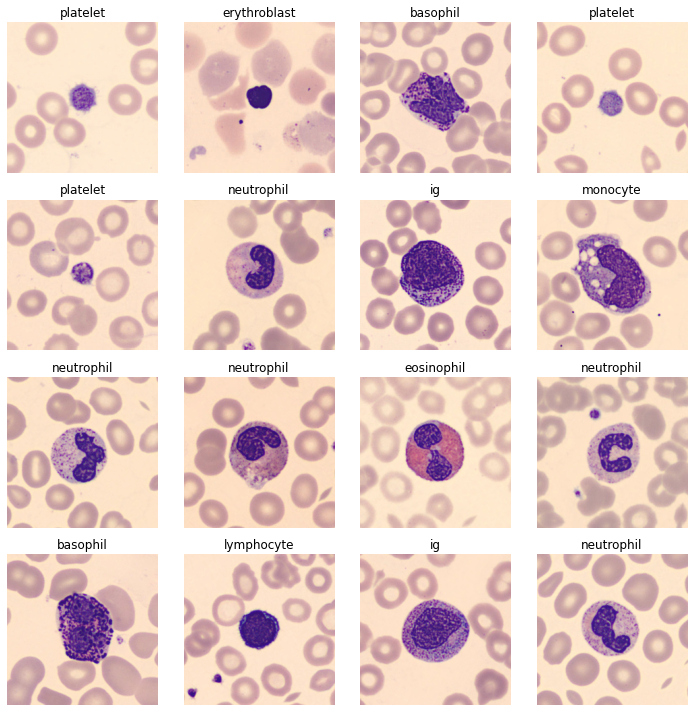

In [12]:
data.show_batch(rows=4, figsize=(10,10))

In [13]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [14]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.674773,0.245369,0.918049,00:28
1,0.332311,0.181744,0.936098,00:26


In [24]:
learn.save('stage1_resnet18')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


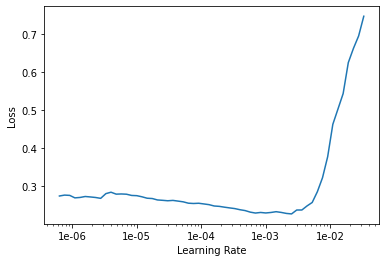

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.167031,0.112633,0.966829,00:31
1,0.090003,0.044762,0.985854,00:30


In [30]:
learn.save('stage2_resnet18')

In [31]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.089814,0.141118,0.957073,00:31
1,0.066335,0.039476,0.985854,00:30


In [32]:
learn.export('model_resnet18.pkl')

In [37]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=8, bias=True)
)

In [ ]:
learn